In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -U sentence-transformers
! pip install plotly
! pip install pyyaml==5.4.1
! apt-get install graphviz graphviz-dev
! pip install pygraphviz
# ! pip install umap-
# ! pip install pyamg

     |████████████████████████████████| 79 kB 8.8 MB/s 
     |████████████████████████████████| 4.2 MB 64.8 MB/s 
     |████████████████████████████████| 1.2 MB 59.2 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 70.9 MB/s 
     |████████████████████████████████| 6.6 MB 59.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=cf2cea9ad0a3414ed5356fc18da31694df0aaff286a07a6d6257f13cad4ef841
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 636 kB 30.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successful

In [3]:
# ! cp ./drive/MyDrive/Datasets/twitter/dg_utils.py ./
! cp ./drive/MyDrive/dailydialog/airways_rebalanced.pkl ./
! cp ./drive/MyDrive/dailydialog/dailydialog_w_embd.pkl ./

In [3]:
! unzip scan.zip

Archive:  scan.zip
   creating: scan/
   creating: scan/configs/
  inflating: scan/configs/env.yml    
   creating: scan/configs/pretext/
  inflating: scan/configs/pretext/moco_imagenet100.yml  
  inflating: scan/configs/pretext/moco_imagenet200.yml  
  inflating: scan/configs/pretext/moco_imagenet50.yml  
  inflating: scan/configs/pretext/simclr_cifar10.yml  
  inflating: scan/configs/pretext/simclr_cifar20.yml  
  inflating: scan/configs/pretext/simclr_stl10.yml  
   creating: scan/configs/scan/
  inflating: scan/configs/scan/imagenet_eval.yml  
  inflating: scan/configs/scan/scan_cifar10.yml  
  inflating: scan/configs/scan/scan_cifar20.yml  
  inflating: scan/configs/scan/scan_imagenet_100.yml  
  inflating: scan/configs/scan/scan_imagenet_200.yml  
  inflating: scan/configs/scan/scan_imagenet_50.yml  
  inflating: scan/configs/scan/scan_stl10.yml  
   creating: scan/configs/selflabel/
  inflating: scan/configs/selflabel/selflabel_cifar10.yml  
  inflating: scan/configs/selflabel/s

In [38]:
# %load_ext autoreload
# %autoreload 2
from dg_utils import *
import sys
sys.path.append('/content/scan')
from scan import  scan_model

import pandas as pd
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
# import networkx as nx
# from IPython.display import Image
import pickle 
import random

# Загрузка датасетов

In [39]:
df_twitter = pd.read_pickle("./airways_rebalanced.pkl")
df_daily = pd.read_pickle("./dailydialog_w_embd.pkl")


In [40]:
twitter_list = df_twitter.dialog.tolist()
twitter_list[1200]

['@AlaskaAir it says you open at 5:15 @317258 where is everyone? 🤔 #helloooooo https://t.co/WePfUANLsZ',
 '@429415 @317258 Ticket counter opens at 615 is what I see on our website.\n -Andre',
 '@AlaskaAir @317258 all good! They just showed up thanks Andre',
 '@429415 That is good news.\n -Andre']

In [41]:
daily_list = df_daily.loc[df_daily.topic == 8, :].dialog.to_list()
daily_list[:1]

[["Everything's gone wrong . ",
  " I know , it's not as I had planned . ",
  ' What are we going to do now ? ',
  " I'll speak to Bob , he'll be able to help us . "]]

In [42]:
# Длина датасетов

len(twitter_list), len(daily_list)

(8081, 1924)

In [7]:
# Среднее количество высказываний в диалоге

sum([len(d) for d in twitter_list]) / len(twitter_list), sum([len(d) for d in daily_list]) / len(daily_list)

(3.6134141814131913, 7.484407484407485)

# T-SNE визуализация

Выберем подвыборки датасетов длиной 1000 диалогов.

In [ ]:
daily_small = random.sample(daily_list, 1000)
twitter_small = random.sample(twitter_list, 1000)

In [ ]:
twitter_small_emb = TurboDataset(twitter_small,
                        preprocessor=Preproccesing(company_words=["Delta", "AmericanAir", "British_Airways", "SouthwestAir",
                        "AirAsiaSupport", "AlaskaAir"]),
                        embedder=Embbeding(embder_name="all-distilroberta-v1", normalize=True),
                        pad_start_end_utter=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preproccesing :   0%|          | 0/1000 [00:00<?, ?it/s]

Embedding:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t_sne = TSNE(n_components=2, learning_rate=500, verbose=3, n_jobs=-1, perplexity=50,
            early_exaggeration=20, n_iter=1000,
             init="pca",

            metric='euclidean')

tsne_emb = t_sne.fit_transform(twitter_small_emb.get_all_embds())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3666 samples in 0.003s...
[t-SNE] Computed neighbors for 3666 samples in 1.696s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3666
[t-SNE] Computed conditional probabilities for sample 2000 / 3666
[t-SNE] Computed conditional probabilities for sample 3000 / 3666
[t-SNE] Computed conditional probabilities for sample 3666 / 3666
[t-SNE] Mean sigma: 0.272278
[t-SNE] Computed conditional probabilities in 0.316s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 154.6837769, gradient norm = 0.2897013 (50 iterations in 2.846s)
[t-SNE] Iteration 100: error = 157.5312195, gradient norm = 0.2704444 (50 iterations in 4.140s)
[t-SNE] Iteration 150: error = 158.7822723, gradient norm = 0.2550235 (50 iterations in 3.063s)
[t-SNE] Iteration 200: error = 160.2911224, gradient norm = 0.2488400 (50 iterations in 2.714s)
[t-SNE] Iteration 250: error = 159.9557800, gradient norm = 0.2509763 (50 iterations in 3.115s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 159.955780
[t-SNE] Iteration 300: error = 2.4951491, gradient norm = 0.0026611 (50 iterations in 2.325s)
[t-SNE] Iteration 350: error = 2.2355711, gradient norm = 0.0009113 (50 iterations in 2.405s)
[t-SNE] Iteration 400: error = 2.1541896, gradient norm = 0.0003262 (50 iterations in 1.656s)
[t-SNE] Iteration 450: error = 2.1206408, gradient norm = 0.0001875 (50 iterations in 1.678s)
[t-SNE] Iteration 500: error = 2.1007600, gradient norm = 0.000182

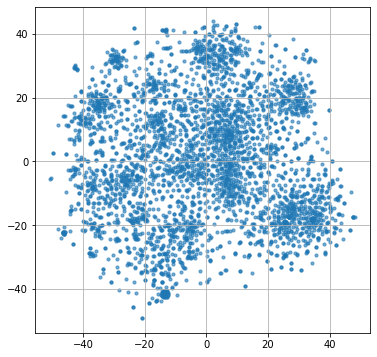

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=10, alpha=0.6)
plt.grid()
plt.savefig("tsne_twitter.svg")

In [ ]:
daily_small_emb = TurboDataset(daily_small,
                        preprocessor=Preproccesing(company_words=["Delta", "AmericanAir", "British_Airways", "SouthwestAir",
                        "AirAsiaSupport", "AlaskaAir"]),
                        embedder=Embbeding(embder_name="all-distilroberta-v1", normalize=True),
                        pad_start_end_utter=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preproccesing :   0%|          | 0/1000 [00:00<?, ?it/s]

Embedding:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
t_sne = TSNE(n_components=2, learning_rate=500, verbose=3, n_jobs=-1, perplexity=50,
            early_exaggeration=20, n_iter=1000,
             init="pca",

            metric='euclidean')

tsne_emb = t_sne.fit_transform(daily_small_emb.get_all_embds())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7474 samples in 0.005s...
[t-SNE] Computed neighbors for 7474 samples in 5.300s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7474
[t-SNE] Computed conditional probabilities for sample 2000 / 7474
[t-SNE] Computed conditional probabilities for sample 3000 / 7474
[t-SNE] Computed conditional probabilities for sample 4000 / 7474
[t-SNE] Computed conditional probabilities for sample 5000 / 7474
[t-SNE] Computed conditional probabilities for sample 6000 / 7474
[t-SNE] Computed conditional probabilities for sample 7000 / 7474
[t-SNE] Computed conditional probabilities for sample 7474 / 7474
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.619s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 156.0484619, gradient norm = 0.0671293 (50 iterations in 5.764s)
[t-SNE] Iteration 100: error = 156.0555115, gradient norm = 0.0458616 (50 iterations in 6.571s)
[t-SNE] Iteration 150: error = 156.0058746, gradient norm = 0.0490526 (50 iterations in 7.085s)
[t-SNE] Iteration 200: error = 156.0442810, gradient norm = 0.0468426 (50 iterations in 7.418s)
[t-SNE] Iteration 250: error = 155.9388580, gradient norm = 0.0480397 (50 iterations in 7.265s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 155.938858
[t-SNE] Iteration 300: error = 2.9923754, gradient norm = 0.0009939 (50 iterations in 4.839s)
[t-SNE] Iteration 350: error = 2.6785932, gradient norm = 0.0003563 (50 iterations in 3.561s)
[t-SNE] Iteration 400: error = 2.5426364, gradient norm = 0.0002099 (50 iterations in 3.575s)
[t-SNE] Iteration 450: error = 2.4703193, gradient norm = 0.0001573 (50 iterations in 3.532s)
[t-SNE] Iteration 500: error = 2.4258966, gradient norm = 0.000116

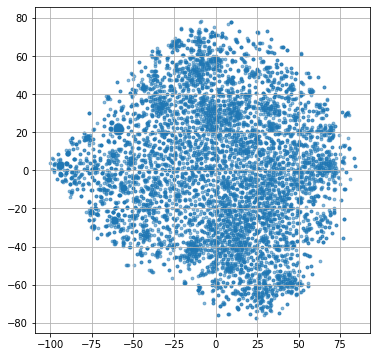

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=8, alpha=0.5)
plt.grid()
plt.savefig("tsne_daily.svg")

# Измерение качества кластеризации

In [88]:
def entropy(adj: np.ndarray, eps=1e-4) -> float:
    
    return ((- adj * np.log(adj+ eps)).sum(axis=1) / np.log(adj.shape[1])).mean()

def train(path, n_clust):
    with open(path, "rb") as f:
        dataset = pickle.load(f)

    X = dataset.get_all_embds()
    # cluster = Birch(n_clusters=n_clust, threshold=0.01)
    cluster = scan_model(X, n_clust, num_head=1, batch_size=64,
                        epoch=15, learning_rate=1e-5, entropy_weight=3,
                        lr_decay_rate=10)
    labels = cluster.predict(X)

    main_model = TurboModel(dataset=dataset,
                    v_giv_u_predictor=cluster.predict,
                    is_soft_predicter=False,
                    num_v=n_clust,
                    # node_labeler=node_labeler,
                    pad_start_end_utter=True)

    adj_mat, p_u_giv_v = main_model.build_graph()

    print("-"*20)
    name = "n_clust=" + str(n_clust) + "_" + path.split("/")[-1].split(".")[0] + "_" + cluster.__repr__()
    print(name)
    metrics = [
               silhouette_score(X, labels),
               calinski_harabasz_score(X, labels),
               davies_bouldin_score(X, labels),
               entropy(adj_mat),
               ]
    metrics = " & ".join([str(round(x, 3)) for x in metrics])
    print(metrics)
    print("-"*20)

    return {name: metrics}

In [92]:
paths = [
        './drive/MyDrive/dailydialog/twitter_mpnet.pickle',
        "./drive/MyDrive/dailydialog/work_mpnet.pickle",
        "./drive/MyDrive/dailydialog/twitter_roberta.pickle",
         "./drive/MyDrive/dailydialog/work_roberta.pickle",
        "./drive/MyDrive/dailydialog/twitter_minilm.pickle",
        "./drive/MyDrive/dailydialog/work_minilm.pickle",
        #  "./drive/MyDrive/Datasets/dailydialog/tourism_mpnet.pickle",
        #  "./drive/MyDrive/Datasets/dailydialog/tourism_roberta.pickle"
         ]

result = []
for k_clust in [5, 10, 15]:
    for ds in paths:
        res = train(ds, k_clust)
        result.append(res)


Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6089e+00 (1.6089e+00)	Entropy 1.6092e+00 (1.6092e+00)
Epoch: [0][ 25/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6088e+00 (1.6089e+00)	Entropy 1.6092e+00 (1.6092e+00)
Epoch: [0][ 50/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6088e+00 (1.6088e+00)	Entropy 1.6092e+00 (1.6092e+00)
Epoch: [0][ 75/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6087e+00 (1.6088e+00)	Entropy 1.6091e+00 (1.6092e+00)
Epoch: [0][100/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6086e+00 (1.6088e+00)	Entropy 1.6091e+00 (1.6092e+00)
Epoch: [0][125/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6086e+00 (1.6087e+00)	Entropy 1.6091e+00 (1.6092e+00)
Epoch: [0][150/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.608

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=5_twitter_mpnet_SCAN
0.042 & 1117.515 & 4.169 & 0.576
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6090e+00 (1.6090e+00)	Entropy 1.6093e+00 (1.6093e+00)
Epoch: [0][ 25/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6089e+00 (1.6090e+00)	Entropy 1.6093e+00 (1.6093e+00)
Epoch: [0][ 50/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6090e+00 (1.6090e+00)	Entropy 1.6093e+00 (1.6093e+00)
Epoch: [0][ 75/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6089e+00 (1.6090e+00)	Entropy 1.6093e+00 (1.6093e+00)
Epoch: [0][100/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6089e+00 (1.6089e+00)	Entropy 1.6092e+00 (1.6093e+00)
Epoch: [0][125/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6088e+00 (1.6089e+00)	Entropy

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=5_work_mpnet_SCAN
0.017 & 230.752 & 5.992 & 0.717
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6090e+00 (1.6090e+00)	Entropy 1.6093e+00 (1.6093e+00)
Epoch: [0][ 25/365]	Total Loss -1.6097e+00 (-1.6096e+00)	Consistency Loss 1.6089e+00 (1.6089e+00)	Entropy 1.6093e+00 (1.6093e+00)
Epoch: [0][ 50/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6088e+00 (1.6089e+00)	Entropy 1.6092e+00 (1.6092e+00)
Epoch: [0][ 75/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6088e+00 (1.6089e+00)	Entropy 1.6092e+00 (1.6092e+00)
Epoch: [0][100/365]	Total Loss -1.6097e+00 (-1.6096e+00)	Consistency Loss 1.6088e+00 (1.6089e+00)	Entropy 1.6092e+00 (1.6092e+00)
Epoch: [0][125/365]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6087e+00 (1.6088e+00)	Entropy 1.6

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=5_twitter_roberta_SCAN
0.037 & 947.797 & 4.569 & 0.625
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6092e+00 (1.6092e+00)	Entropy 1.6094e+00 (1.6094e+00)
Epoch: [0][ 25/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6092e+00 (1.6092e+00)	Entropy 1.6094e+00 (1.6094e+00)
Epoch: [0][ 50/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6092e+00 (1.6092e+00)	Entropy 1.6094e+00 (1.6094e+00)
Epoch: [0][ 75/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6092e+00 (1.6092e+00)	Entropy 1.6094e+00 (1.6094e+00)
Epoch: [0][100/180]	Total Loss -1.6096e+00 (-1.6096e+00)	Consistency Loss 1.6092e+00 (1.6092e+00)	Entropy 1.6094e+00 (1.6094e+00)
Epoch: [0][125/180]	Total Loss -1.6097e+00 (-1.6096e+00)	Consistency Loss 1.6092e+00 (1.6092e+00)	Entrop

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=5_work_roberta_SCAN
0.024 & 258.829 & 5.563 & 0.718
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -1.6099e+00 (-1.6099e+00)	Consistency Loss 1.6080e+00 (1.6080e+00)	Entropy 1.6089e+00 (1.6089e+00)
Epoch: [0][ 25/365]	Total Loss -1.6099e+00 (-1.6099e+00)	Consistency Loss 1.6077e+00 (1.6078e+00)	Entropy 1.6088e+00 (1.6089e+00)
Epoch: [0][ 50/365]	Total Loss -1.6099e+00 (-1.6099e+00)	Consistency Loss 1.6076e+00 (1.6078e+00)	Entropy 1.6088e+00 (1.6089e+00)
Epoch: [0][ 75/365]	Total Loss -1.6099e+00 (-1.6099e+00)	Consistency Loss 1.6077e+00 (1.6078e+00)	Entropy 1.6088e+00 (1.6088e+00)
Epoch: [0][100/365]	Total Loss -1.6100e+00 (-1.6099e+00)	Consistency Loss 1.6077e+00 (1.6077e+00)	Entropy 1.6088e+00 (1.6088e+00)
Epoch: [0][125/365]	Total Loss -1.6102e+00 (-1.6100e+00)	Consistency Loss 1.6073e+00 (1.6077e+00)	Entropy 1

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=5_twitter_minilm_SCAN
0.036 & 901.678 & 4.493 & 0.624
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -1.6098e+00 (-1.6098e+00)	Consistency Loss 1.6085e+00 (1.6085e+00)	Entropy 1.6091e+00 (1.6091e+00)
Epoch: [0][ 25/180]	Total Loss -1.6098e+00 (-1.6098e+00)	Consistency Loss 1.6084e+00 (1.6084e+00)	Entropy 1.6091e+00 (1.6091e+00)
Epoch: [0][ 50/180]	Total Loss -1.6098e+00 (-1.6098e+00)	Consistency Loss 1.6084e+00 (1.6084e+00)	Entropy 1.6091e+00 (1.6091e+00)
Epoch: [0][ 75/180]	Total Loss -1.6098e+00 (-1.6098e+00)	Consistency Loss 1.6085e+00 (1.6084e+00)	Entropy 1.6091e+00 (1.6091e+00)
Epoch: [0][100/180]	Total Loss -1.6099e+00 (-1.6098e+00)	Consistency Loss 1.6085e+00 (1.6084e+00)	Entropy 1.6092e+00 (1.6091e+00)
Epoch: [0][125/180]	Total Loss -1.6098e+00 (-1.6098e+00)	Consistency Loss 1.6084e+00 (1.6084e+00)	Entropy

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=5_work_minilm_SCAN
0.021 & 247.22 & 5.596 & 0.705
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -2.3027e+00 (-2.3027e+00)	Consistency Loss 2.3013e+00 (2.3013e+00)	Entropy 2.3020e+00 (2.3020e+00)
Epoch: [0][ 25/365]	Total Loss -2.3027e+00 (-2.3027e+00)	Consistency Loss 2.3012e+00 (2.3013e+00)	Entropy 2.3020e+00 (2.3020e+00)
Epoch: [0][ 50/365]	Total Loss -2.3028e+00 (-2.3027e+00)	Consistency Loss 2.3012e+00 (2.3012e+00)	Entropy 2.3020e+00 (2.3020e+00)
Epoch: [0][ 75/365]	Total Loss -2.3027e+00 (-2.3027e+00)	Consistency Loss 2.3011e+00 (2.3012e+00)	Entropy 2.3019e+00 (2.3020e+00)
Epoch: [0][100/365]	Total Loss -2.3028e+00 (-2.3027e+00)	Consistency Loss 2.3011e+00 (2.3012e+00)	Entropy 2.3019e+00 (2.3019e+00)
Epoch: [0][125/365]	Total Loss -2.3027e+00 (-2.3027e+00)	Consistency Loss 2.3009e+00 (2.3011e+00)	Entropy 2.3

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=10_twitter_mpnet_SCAN
0.032 & 626.664 & 4.569 & 0.663
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -2.3027e+00 (-2.3027e+00)	Consistency Loss 2.3016e+00 (2.3016e+00)	Entropy 2.3022e+00 (2.3022e+00)
Epoch: [0][ 25/180]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3014e+00 (2.3016e+00)	Entropy 2.3021e+00 (2.3022e+00)
Epoch: [0][ 50/180]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3015e+00 (2.3016e+00)	Entropy 2.3021e+00 (2.3022e+00)
Epoch: [0][ 75/180]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3014e+00 (2.3015e+00)	Entropy 2.3021e+00 (2.3021e+00)
Epoch: [0][100/180]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3013e+00 (2.3015e+00)	Entropy 2.3021e+00 (2.3021e+00)
Epoch: [0][125/180]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3013e+00 (2.3014e+00)	Entropy

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=10_work_mpnet_SCAN
0.014 & 176.676 & 5.117 & 0.809
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3022e+00 (2.3022e+00)	Entropy 2.3025e+00 (2.3025e+00)
Epoch: [0][ 25/365]	Total Loss -2.3027e+00 (-2.3028e+00)	Consistency Loss 2.3022e+00 (2.3021e+00)	Entropy 2.3024e+00 (2.3025e+00)
Epoch: [0][ 50/365]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3021e+00 (2.3021e+00)	Entropy 2.3024e+00 (2.3025e+00)
Epoch: [0][ 75/365]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3021e+00 (2.3021e+00)	Entropy 2.3024e+00 (2.3024e+00)
Epoch: [0][100/365]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3020e+00 (2.3021e+00)	Entropy 2.3024e+00 (2.3024e+00)
Epoch: [0][125/365]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3020e+00 (2.3021e+00)	Entropy 2.

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=10_twitter_roberta_SCAN
0.031 & 562.999 & 4.465 & 0.68
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -2.3028e+00 (-2.3028e+00)	Consistency Loss 2.3012e+00 (2.3012e+00)	Entropy 2.3020e+00 (2.3020e+00)
Epoch: [0][ 25/180]	Total Loss -2.3029e+00 (-2.3028e+00)	Consistency Loss 2.3012e+00 (2.3012e+00)	Entropy 2.3021e+00 (2.3020e+00)
Epoch: [0][ 50/180]	Total Loss -2.3029e+00 (-2.3028e+00)	Consistency Loss 2.3012e+00 (2.3012e+00)	Entropy 2.3020e+00 (2.3020e+00)
Epoch: [0][ 75/180]	Total Loss -2.3028e+00 (-2.3029e+00)	Consistency Loss 2.3010e+00 (2.3012e+00)	Entropy 2.3019e+00 (2.3020e+00)
Epoch: [0][100/180]	Total Loss -2.3029e+00 (-2.3029e+00)	Consistency Loss 2.3011e+00 (2.3012e+00)	Entropy 2.3020e+00 (2.3020e+00)
Epoch: [0][125/180]	Total Loss -2.3029e+00 (-2.3029e+00)	Consistency Loss 2.3012e+00 (2.3012e+00)	Entrop

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=10_work_roberta_SCAN
0.021 & 165.634 & 5.414 & 0.809
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -2.3029e+00 (-2.3029e+00)	Consistency Loss 2.3017e+00 (2.3017e+00)	Entropy 2.3023e+00 (2.3023e+00)
Epoch: [0][ 25/365]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3017e+00 (2.3017e+00)	Entropy 2.3023e+00 (2.3024e+00)
Epoch: [0][ 50/365]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3016e+00 (2.3017e+00)	Entropy 2.3023e+00 (2.3024e+00)
Epoch: [0][ 75/365]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3017e+00 (2.3017e+00)	Entropy 2.3023e+00 (2.3023e+00)
Epoch: [0][100/365]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3016e+00 (2.3017e+00)	Entropy 2.3023e+00 (2.3023e+00)
Epoch: [0][125/365]	Total Loss -2.3031e+00 (-2.3030e+00)	Consistency Loss 2.3015e+00 (2.3016e+00)	Entropy 

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=10_twitter_minilm_SCAN
0.03 & 585.485 & 4.278 & 0.679
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3014e+00 (2.3014e+00)	Entropy 2.3022e+00 (2.3022e+00)
Epoch: [0][ 25/180]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3015e+00 (2.3014e+00)	Entropy 2.3022e+00 (2.3022e+00)
Epoch: [0][ 50/180]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3014e+00 (2.3014e+00)	Entropy 2.3022e+00 (2.3022e+00)
Epoch: [0][ 75/180]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3013e+00 (2.3014e+00)	Entropy 2.3022e+00 (2.3022e+00)
Epoch: [0][100/180]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3014e+00 (2.3014e+00)	Entropy 2.3022e+00 (2.3022e+00)
Epoch: [0][125/180]	Total Loss -2.3030e+00 (-2.3030e+00)	Consistency Loss 2.3015e+00 (2.3014e+00)	Entropy

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=10_work_minilm_SCAN
0.021 & 175.363 & 5.003 & 0.81
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -2.7082e+00 (-2.7082e+00)	Consistency Loss 2.7074e+00 (2.7074e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 25/365]	Total Loss -2.7082e+00 (-2.7082e+00)	Consistency Loss 2.7073e+00 (2.7073e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 50/365]	Total Loss -2.7083e+00 (-2.7082e+00)	Consistency Loss 2.7073e+00 (2.7073e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 75/365]	Total Loss -2.7083e+00 (-2.7082e+00)	Consistency Loss 2.7072e+00 (2.7073e+00)	Entropy 2.7077e+00 (2.7077e+00)
Epoch: [0][100/365]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7070e+00 (2.7072e+00)	Entropy 2.7077e+00 (2.7077e+00)
Epoch: [0][125/365]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7070e+00 (2.7072e+00)	Entropy 2.

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=15_twitter_mpnet_SCAN
0.024 & 475.495 & 4.457 & 0.693
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -2.7082e+00 (-2.7082e+00)	Consistency Loss 2.7071e+00 (2.7071e+00)	Entropy 2.7077e+00 (2.7077e+00)
Epoch: [0][ 25/180]	Total Loss -2.7082e+00 (-2.7082e+00)	Consistency Loss 2.7071e+00 (2.7071e+00)	Entropy 2.7077e+00 (2.7077e+00)
Epoch: [0][ 50/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7069e+00 (2.7070e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][ 75/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7070e+00 (2.7070e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][100/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7068e+00 (2.7070e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][125/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7068e+00 (2.7069e+00)	Entropy

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=15_work_mpnet_SCAN
0.005 & 136.29 & 4.779 & 0.832
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -2.7082e+00 (-2.7082e+00)	Consistency Loss 2.7074e+00 (2.7074e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 25/365]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7073e+00 (2.7073e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 50/365]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7073e+00 (2.7073e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 75/365]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7072e+00 (2.7073e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][100/365]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7072e+00 (2.7073e+00)	Entropy 2.7077e+00 (2.7078e+00)
Epoch: [0][125/365]	Total Loss -2.7084e+00 (-2.7083e+00)	Consistency Loss 2.7070e+00 (2.7072e+00)	Entropy 2.7

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=15_twitter_roberta_SCAN
0.024 & 447.426 & 4.418 & 0.694
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -2.7082e+00 (-2.7082e+00)	Consistency Loss 2.7074e+00 (2.7074e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 25/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7073e+00 (2.7074e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 50/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7073e+00 (2.7074e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][ 75/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7073e+00 (2.7074e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][100/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7074e+00 (2.7074e+00)	Entropy 2.7078e+00 (2.7078e+00)
Epoch: [0][125/180]	Total Loss -2.7083e+00 (-2.7083e+00)	Consistency Loss 2.7073e+00 (2.7074e+00)	Entro

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=15_work_roberta_SCAN
0.023 & 135.245 & 4.937 & 0.829
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/365]	Total Loss -2.7085e+00 (-2.7085e+00)	Consistency Loss 2.7067e+00 (2.7067e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][ 25/365]	Total Loss -2.7085e+00 (-2.7085e+00)	Consistency Loss 2.7066e+00 (2.7067e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][ 50/365]	Total Loss -2.7085e+00 (-2.7085e+00)	Consistency Loss 2.7066e+00 (2.7066e+00)	Entropy 2.7075e+00 (2.7076e+00)
Epoch: [0][ 75/365]	Total Loss -2.7086e+00 (-2.7085e+00)	Consistency Loss 2.7065e+00 (2.7066e+00)	Entropy 2.7076e+00 (2.7075e+00)
Epoch: [0][100/365]	Total Loss -2.7086e+00 (-2.7085e+00)	Consistency Loss 2.7066e+00 (2.7066e+00)	Entropy 2.7076e+00 (2.7075e+00)
Epoch: [0][125/365]	Total Loss -2.7086e+00 (-2.7085e+00)	Consistency Loss 2.7065e+00 (2.7065e+00)	Entropy 

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=15_twitter_minilm_SCAN
0.024 & 439.935 & 4.43 & 0.696
--------------------
Get dataset and dataloaders
Get optimizer
Get loss
Starting main loop
Epoch 1/15
---------------
Adjusted learning rate to 0.00001
Train ...
Epoch: [0][  0/180]	Total Loss -2.7086e+00 (-2.7086e+00)	Consistency Loss 2.7065e+00 (2.7065e+00)	Entropy 2.7075e+00 (2.7075e+00)
Epoch: [0][ 25/180]	Total Loss -2.7085e+00 (-2.7085e+00)	Consistency Loss 2.7067e+00 (2.7067e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][ 50/180]	Total Loss -2.7086e+00 (-2.7085e+00)	Consistency Loss 2.7066e+00 (2.7066e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][ 75/180]	Total Loss -2.7084e+00 (-2.7085e+00)	Consistency Loss 2.7067e+00 (2.7066e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][100/180]	Total Loss -2.7085e+00 (-2.7085e+00)	Consistency Loss 2.7067e+00 (2.7066e+00)	Entropy 2.7076e+00 (2.7076e+00)
Epoch: [0][125/180]	Total Loss -2.7086e+00 (-2.7085e+00)	Consistency Loss 2.7065e+00 (2.7066e+00)	Entropy

Graph building: : 0it [00:00, ?it/s]

--------------------
n_clust=15_work_minilm_SCAN
0.022 & 140.048 & 5.132 & 0.826
--------------------


In [93]:
result

[{'n_clust=5_twitter_mpnet_SCAN': '0.042 & 1117.515 & 4.169 & 0.576'},
 {'n_clust=5_work_mpnet_SCAN': '0.017 & 230.752 & 5.992 & 0.717'},
 {'n_clust=5_twitter_roberta_SCAN': '0.037 & 947.797 & 4.569 & 0.625'},
 {'n_clust=5_work_roberta_SCAN': '0.024 & 258.829 & 5.563 & 0.718'},
 {'n_clust=5_twitter_minilm_SCAN': '0.036 & 901.678 & 4.493 & 0.624'},
 {'n_clust=5_work_minilm_SCAN': '0.021 & 247.22 & 5.596 & 0.705'},
 {'n_clust=10_twitter_mpnet_SCAN': '0.032 & 626.664 & 4.569 & 0.663'},
 {'n_clust=10_work_mpnet_SCAN': '0.014 & 176.676 & 5.117 & 0.809'},
 {'n_clust=10_twitter_roberta_SCAN': '0.031 & 562.999 & 4.465 & 0.68'},
 {'n_clust=10_work_roberta_SCAN': '0.021 & 165.634 & 5.414 & 0.809'},
 {'n_clust=10_twitter_minilm_SCAN': '0.03 & 585.485 & 4.278 & 0.679'},
 {'n_clust=10_work_minilm_SCAN': '0.021 & 175.363 & 5.003 & 0.81'},
 {'n_clust=15_twitter_mpnet_SCAN': '0.024 & 475.495 & 4.457 & 0.693'},
 {'n_clust=15_work_mpnet_SCAN': '0.005 & 136.29 & 4.779 & 0.832'},
 {'n_clust=15_twitter_rob

# Визуализация графа

In [ ]:
def print_graph(path_to_dataset: str, n_clust=5):
    with open(path_to_dataset, "rb") as f:
        dataset = pickle.load(f)
    
    X = dataset.get_all_embds()
    cluster = GaussianMixture(n_components=n_clust, covariance_type="diag")
    labels = cluster.fit_predict(X)

    main_model = TurboModel(dataset=dataset,
                    v_giv_u_predictor=cluster.predict_proba,
                    is_soft_predicter=True,
                    num_v=n_clust,
                    # node_labeler=node_labeler,
                    pad_start_end_utter=True)

    adj_mat, p_u_giv_v = main_model.build_graph()

    node_labeler = TfIdfStat(dataset=dataset,
                        top_k=200, max_df=0.95, min_df=1)
    
    return main_model.draw_graph(node_labeler,  min_prob=0.07)


In [ ]:
dataset = TurboDataset(twitter_list,
                        preprocessor=Preproccesing(company_words=["Delta", "AmericanAir", "British_Airways", "SouthwestAir",
                        "AirAsiaSupport", "AlaskaAir"]),
                        embedder=Embbeding(embder_name="all-distilroberta-v1", normalize=True),
                        pad_start_end_utter=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Preproccesing :   0%|          | 0/8081 [00:00<?, ?it/s]

Embedding:   0%|          | 0/8081 [00:00<?, ?it/s]

In [ ]:
file_to_dump = open("./drive/MyDrive/Datasets/dailydialog/twitter_roberta.pickle", "wb")
pickle.dump(dataset, file_to_dump)

In [ ]:
# clust_model = KMeans(n_clusters=5)
clust_model = GaussianMixture(n_components=5, max_iter=100, verbose=5)
clust_model.fit(dataset.get_all_embds())

Initialization 0
Initialization converged: True	 time lapse 72.55874s	 ll 2487.92291


GaussianMixture(n_components=5, verbose=5)

In [ ]:
# node_labeler = TfIdfStat(dataset=dataset,
#                         top_k=100)

# node_labeler = SelfLabelStat(dataset=dataset, top_k_utter_to_find=50, lenth_bound=(3, 6))

main_model = TurboModel(dataset=dataset,
                        v_giv_u_predictor=clust_model.predict_proba,
                        is_soft_predicter=True,
                        num_v=5,
                        # node_labeler=node_labeler,
                        pad_start_end_utter=True)

adj_mat, p_u_giv_v = main_model.build_graph()



Graph building: : 0it [00:00, ?it/s]

In [ ]:
node_labeler = TfIdfStat(dataset=dataset,
                        top_k=300, max_df=0.95, min_df=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


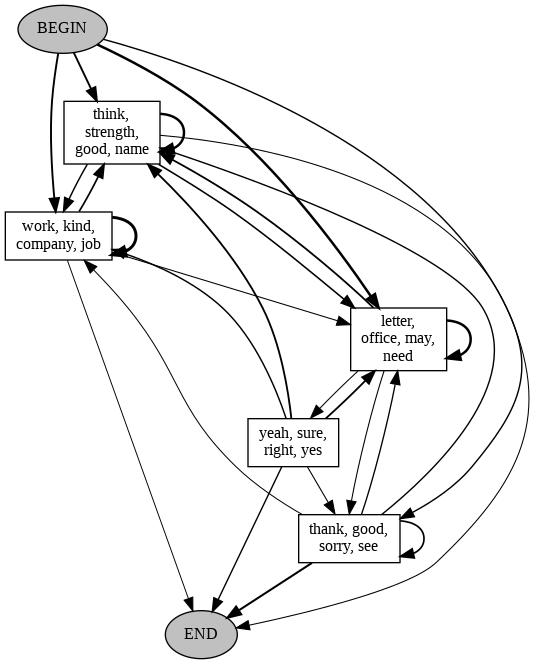

In [ ]:
main_model.draw_graph(node_labeler,  min_prob=0.1)

# Ненужное

In [ ]:
companies = ["Delta", "AmericanAir", "British_Airways", "SouthwestAir",
                "AirAsiaSupport", "AlaskaAir"]
# airways_dict = twitter_dialogs(df_twitter, companies)

In [ ]:
airways_df = pd.concat([v for k, v in airways_dict.items()], ignore_index=True)

In [ ]:
r = np.random.choice((0, 1), p=(0.96, 0.04), size=airways_df.shape[0])

airways_df_reblc = pd.concat([airways_df[airways_df["lens"]>2],
        airways_df.loc[((airways_df.lens == 2)*r).astype(bool), :]], ignore_index=True)


In [ ]:
# df_twitter = pd.read_pickle("./airlines/all_twitter.pkl")
# airways_df_reblc = pd.read_pickle("./airways_rebalanced.pkl")
df_dailydialog = pd.read_pickle("./dailydialog_w_embd.pkl")

In [ ]:
# airways_df_reblc
df_dailydialog

dialog  topic  lens  \
0      [The kitchen stinks . ,  I'll throw out the ga...      1     2   
1      [So Dick , how about getting some coffee for t...      1     5   
2      [Are things still going badly with your houseg...      1     4   
3      [Would you mind waiting a while ? ,  Well , ho...      1     4   
4      [Are you going to the annual party ? I can giv...      1     3   
...                                                  ...    ...   ...   
13113  [You have done an excellent job this year and ...     10     8   
13114  [Lindsay Tipping gave me your name as a refere...     10     6   
13115  [The consignments of chemical instruments have...     10     9   
13116  [good morning . How can I help you ? ,  I'd li...     10    17   
13117  [May I ask you a few questions about insurance...     10    15   

                                            prepr_dialog  \
0           [the kitchen stink, i throw out the garbage]   
1      [so dick how about getting some coffee for ton...   
2      [are thing still going badly with your housegu...   
3      [would you mind waiting a while, well how long...   
4      [are you going to the annual party i can give ...   
...                                                  ...   
13113  [you have done an excellent job this year and ...   
13114  [lindsay tipping gave me your name a a referen...   
13115  [the consignment of chemical instrument have j...   
13116  [good morning how can i help you, i like to op...   
13117  [may i ask you a few question about insurance,...   

                                              embbedings  
0      [[0.024679719, 0.05938055, -0.05356459, -0.053...  
1      [[-0.028688245, 0.010420693, -0.012683313, -0....  
2      [[-0.009853051, -0.039757885, -0.020587418, 0....  
3      [[0.06812938, -0.0001304324, -0.024951018, 0.0...  
4      [[0.0035103378, 0.058215227, 0.0055242223, 0.0...  
...                                                  ...  
13113  [[-0.0036098517, 0.011505732, -0.021393223, 0....  
13114  [[0.054745648, 0.030945422, -0.0063369474, -0....  
13115  [[0.03237458, -0.0012391278, 0.012113363, 0.02...  
13116  [[0.018484995, -0.066232614, -0.008272055, -0....  
13117  [[0.012551695, 0.0073749963, -0.019404816, -0....  

[13118 rows x 5 columns]

In [ ]:
prepr = Preproccesing(companies)
airways_df_reblc["prepr_dialog"] = prepr.preprocessing_corpus(airways_df_reblc["dialog"])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/8081 [00:00<?, ?it/s]

In [ ]:
embdr = Embbeding("prepr_dialog")
airways_df_reblc = embdr.embed(airways_df_reblc)

  0%|          | 0/8081 [00:00<?, ?it/s]

In [ ]:
# airways_df_reblc = pd.read_csv("./airlines/all_airlines_rebalanced.csv")
airways_df_reblc.to_pickle('./airlines/airways_rebalanced.pkl')

In [ ]:
embds_to_concat = df_dailydialog.loc[df_dailydialog.topic==5, "embbedings"].to_numpy()
all_embs = np.concatenate(embds_to_concat, axis=0)
# airways_df.loc[airways_df.lens>2, "embbedings"]
all_embs.shape, all_embs.dtype

((32258, 768), dtype('float32'))

In [ ]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    num_labels = len(set(labels))
    num_samples = X.shape[0]
    print("Num of labels ", set(labels))
    print(*pd.value_counts(labels))
    print("calinski_harabasz_score: ", calinski_harabasz_score(X, labels))
    sil = silhouette_score(X, labels)
    print("silhouette_score: ", sil)
    if num_labels == 1 or num_labels == num_samples or (num_labels == 2 and (-1 in labels)):
        return -1
    else:
        return sil

In [ ]:
grid0 = {"linkage": ['ward', 'complete', 'average', 'single']}
cv = [(slice(None), slice(None))]
searcher0 = GridSearchCV(AgglomerativeClustering(n_clusters=20), grid0, scoring=silhouette_scorer, n_jobs=1,  verbose=3, cv=cv)
searcher0.fit(all_embs)
searcher0.best_params_

In [ ]:
grid1 = {"n_clusters": list(range(5, 15, 1))}
cv = [(slice(None), slice(None))]
searcher1 = GridSearchCV(KMeans(), grid1, scoring=silhouette_scorer, n_jobs=1,  verbose=3, cv=cv)
searcher1.fit(all_embs)
searcher1.best_params_

Fitting 1 folds for each of 10 candidates, totalling 10 fits
Num of labels  {0, 1, 2, 3, 4}
10191 6463 5846 5208 4550
calinski_harabasz_score:  463.55444696726863
silhouette_score:  0.014521368
[CV 1/1] END ......................n_clusters=5;, score=0.015 total time= 2.1min
Num of labels  {0, 1, 2, 3, 4, 5}
8385 6879 5571 4509 3844 3070
calinski_harabasz_score:  432.8850016508891
silhouette_score:  0.015151316
[CV 1/1] END ......................n_clusters=6;, score=0.015 total time= 2.4min
Num of labels  {0, 1, 2, 3, 4, 5, 6}
7424 5617 5597 4880 3687 2618 2435
calinski_harabasz_score:  406.40211727153854
silhouette_score:  0.017887905
[CV 1/1] END ......................n_clusters=7;, score=0.018 total time= 2.4min
Num of labels  {0, 1, 2, 3, 4, 5, 6, 7}
6624 5072 4747 3791 3736 3293 2557 2438
calinski_harabasz_score:  385.74096847759125
silhouette_score:  0.019016301
[CV 1/1] END ......................n_clusters=8;, score=0.019 total time= 2.3min
Num of labels  {0, 1, 2, 3, 4, 5, 6, 7,

{'n_clusters': 14}

In [ ]:
# Fitting 1 folds for each of 10 candidates, totalling 10 fits
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
# 3940 3301 2874 2819 2268 2155 2153 1973 1924 1886 1784 1659 1577 1032 913
# calinski_harabasz_score:  289.7320081989016
# silhouette_score:  0.022253245
# [CV 1/1] END .....................n_clusters=15;, score=0.022 total time= 3.2min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
# 3772 2935 2853 2291 2132 2046 2032 1974 1891 1758 1712 1560 1498 1025 985 899 895
# calinski_harabasz_score:  268.7452318699663
# silhouette_score:  0.0206194
# [CV 1/1] END .....................n_clusters=17;, score=0.021 total time= 3.5min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
# 2855 2677 2559 2236 1922 1889 1766 1763 1749 1736 1688 1627 1469 1441 1412 1062 980 887 540
# calinski_harabasz_score:  253.49347576093913
# silhouette_score:  0.024876487
# [CV 1/1] END .....................n_clusters=19;, score=0.025 total time= 4.4min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
# 2613 2217 2133 2015 1869 1817 1712 1697 1677 1522 1516 1475 1430 1405 1368 1310 1055 1040 972 860 555
# calinski_harabasz_score:  239.66086170771163
# silhouette_score:  0.022099212
# [CV 1/1] END .....................n_clusters=21;, score=0.022 total time= 4.4min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}
# 2238 2103 1952 1890 1766 1635 1610 1582 1518 1486 1364 1354 1340 1330 1324 1274 1127 1068 955 892 868 861 721
# calinski_harabasz_score:  226.84298820696458
# silhouette_score:  0.022258285
# [CV 1/1] END .....................n_clusters=23;, score=0.022 total time= 4.4min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
# 2148 1846 1784 1734 1680 1665 1590 1560 1510 1450 1436 1282 1267 1260 1220 1085 978 961 935 892 877 866 824 720 688
# calinski_harabasz_score:  216.70309193708547
# silhouette_score:  0.02352714
# [CV 1/1] END .....................n_clusters=25;, score=0.024 total time= 4.8min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
# 2106 1807 1785 1590 1542 1528 1474 1432 1400 1371 1288 1286 1244 1234 1205 1145 980 959 926 910 882 847 808 775 639 583 512
# calinski_harabasz_score:  208.4060595875872
# silhouette_score:  0.02436185
# [CV 1/1] END .....................n_clusters=27;, score=0.024 total time= 4.7min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
# 2308 1640 1569 1480 1441 1412 1351 1330 1297 1297 1296 1241 1211 1204 1079 977 972 972 940 926 869 844 826 825 758 694 633 492 374
# calinski_harabasz_score:  199.55648042540943
# silhouette_score:  0.02415449
# [CV 1/1] END .....................n_clusters=29;, score=0.024 total time= 4.9min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30}
# 1698 1605 1597 1569 1533 1393 1230 1212 1189 1176 1164 1125 1113 1024 1011 937 936 927 904 902 899 856 849 805 742 738 678 667 621 583 575
# calinski_harabasz_score:  190.7242907725746
# silhouette_score:  0.02514582
# [CV 1/1] END .....................n_clusters=31;, score=0.025 total time= 5.2min
# Num of labels  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
# 1755 1575 1516 1478 1283 1229 1222 1205 1179 1172 1167 1104 1074 1038 1002 974 965 925 908 878 846 812 811 762 727 648 646 633 631 568 541 504 480
# calinski_harabasz_score:  185.61219928653688
# silhouette_score:  0.023234002
# [CV 1/1] END .....................n_clusters=33;, score=0.023 total time= 5.3min
# {'n_clusters': 31}





# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, -1}
# [CV 1/1] END ..........................eps=0.5;, score=-0.169 total time= 2.6min
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, -1}
# [CV 1/1] END ...........eps=0.5714285714285714;, score=-0.161 total time= 2.6min
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, -1}
# [CV 1/1] END ...........eps=0.6428571428571428;, score=-0.154 total time= 2.6min
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, -1}
# [CV 1/1] END ...........eps=0.7142857142857143;, score=-0.137 total time= 2.6min
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, -1}
# [CV 1/1] END ...........eps=0.7857142857142857;, score=-0.110 total time= 2.5min
# {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, -1}
# [CV 1/1] END ...........eps=0.8571428571428571;, score=-0.039 total time= 2.5min
# {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
# [CV 1/1] END ............eps=0.9285714285714286;, score=0.011 total time= 2.6min
# {0, 1, 2, 3, 4, -1}
# [CV 1/1] END ...........................eps=1.0;, score=0.043 total time= 2.6min
# {0, 1, -1}

In [ ]:
grid2 = {"eps": np.linspace(0.7, 0.85, 10)}
# grid2 = {"eps": [1]}
cv = [(slice(None), slice(None))]
searcher2 = GridSearchCV(DBSCAN(), grid2, scoring=silhouette_scorer, n_jobs=1,  verbose=3, cv=cv)
searcher2.fit(all_embs)
searcher2.best_params_

In [ ]:
print(pd.value_counts(labels))

In [ ]:
labels = searcher2.best_estimator_.fit_predict(all_embs)

In [ ]:
t_sne = TSNE(n_components=2, learning_rate=500, verbose=3, n_jobs=-1, perplexity=50,
            early_exaggeration=20, n_iter=1000,
             init="pca",

            metric='euclidean')

In [ ]:
# rand_idx = np.random.choice(all_embs.shape[0], size=10000, replace=False)
tse_all_embs = t_sne.fit_transform(all_embs)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 32258 samples in 0.024s...
[t-SNE] Computed neighbors for 32258 samples in 96.313s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32258
[t-SNE] Computed conditional probabilities for sample 2000 / 32258
[t-SNE] Computed conditional probabilities for sample 3000 / 32258
[t-SNE] Computed conditional probabilities for sample 4000 / 32258
[t-SNE] Computed conditional probabilities for sample 5000 / 32258
[t-SNE] Computed conditional probabilities for sample 6000 / 32258
[t-SNE] Computed conditional probabilities for sample 7000 / 32258
[t-SNE] Computed conditional probabilities for sample 8000 / 32258
[t-SNE] Computed conditional probabilities for sample 9000 / 32258
[t-SNE] Computed conditional probabilities for sample 10000 / 32258
[t-SNE] Computed conditional probabilities for sample 11000 / 32258
[t-SNE] Computed conditional probabilities for sample 12000 / 32258
[t-SNE] Computed conditional probabilities for s

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] Iteration 50: error = 182.6658020, gradient norm = 0.0000053 (50 iterations in 57.552s)
[t-SNE] Iteration 100: error = 182.6661530, gradient norm = 0.0000000 (50 iterations in 31.562s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 182.666153
[t-SNE] Iteration 150: error = 5.2709370, gradient norm = 0.0021699 (50 iterations in 50.078s)
[t-SNE] Iteration 200: error = 4.0431089, gradient norm = 0.0005680 (50 iterations in 36.595s)
[t-SNE] Iteration 250: error = 3.6960511, gradient norm = 0.0003093 (50 iterations in 29.870s)
[t-SNE] Iteration 300: error = 3.4936223, gradient norm = 0.0002057 (50 iterations in 28.319s)
[t-SNE] Iteration 350: error = 3.3554013, gradient norm = 0.0001511 (50 iterations in 28.538s)
[t-SNE] Iteration 400: error = 3.2523451, gradient norm = 0.0001204 (50 iterations in 28.105s)
[t-SNE] Iteration 450: error = 3.1719532, gradient norm = 0.0000989 (50 iterations in 27.544s)
[t-SNE

In [ ]:
all_text = []
for curr_dialog in df_dailydialog.loc[df_dailydialog.topic==5, "prepr_dialog"].to_list():
    all_text += curr_dialog

In [ ]:

df_for_scatter = pd.DataFrame({
    "x": tse_all_embs[:,0],
    "y": tse_all_embs[:,1],
    "text":all_text,
    #  "color":labels.astype(str)
})

ex.scatter(data_frame=df_for_scatter,
            x="x",
            y="y",
            hover_data=["text"],
            # color="color",
            height=800
)